# Import Libraries

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from collections import Counter
import optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Seed setup and Xavier weight initialization utilities for models.

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  


def init_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [ ]:
set_seed(42)

# Data loading and preprocessing pipeline for eye-disease image classification.

In [ ]:
class EyeDiseaseDataset:
    def __init__(self, dataset_path, img_size=(224, 224), batch_size=32, train_split=0.7, val_split=0.2):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = 1 - (train_split + val_split)

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Load dataset
        self.dataset = datasets.ImageFolder(root=self.dataset_path, transform=self.transform)
        self.class_names = self.dataset.classes

        # Get class-wise image count
        self.class_counts = self.get_class_distribution()

        # Split dataset
        self.train_dataset, self.val_dataset, self.test_dataset = self.split_dataset()

        print("Training set class distribution:", len(self.train_dataset))
        print("Validation set class distribution:", len(self.val_dataset))
        print("Test set class distribution:", len(self.test_dataset))
       
        # Create dataloaders
        self.train_loader = self.create_dataloader(self.train_dataset, shuffle=True)
        self.val_loader = self.create_dataloader(self.val_dataset, shuffle=False)
        self.test_loader = self.create_dataloader(self.test_dataset, shuffle=False)

    def get_class_distribution(self):
        """ Count number of images per class """
        class_counts = Counter(self.dataset.targets)
        return {self.class_names[i]: class_counts[i] for i in range(len(self.class_names))}
    def split_dataset(self):
        """ Split dataset into train, validation, and test sets """
        targets = self.dataset.targets  # Get class labels
        indices = np.arange(len(targets))  # Generate indices

        # First split: Separate out test data
        train_val_idx, test_idx, train_val_targets, test_targets = train_test_split(
            indices, targets, test_size=self.test_split, stratify=targets, random_state=42
        )

        # Second split: Separate train and validation data
        train_idx, val_idx, _, _ = train_test_split(
            train_val_idx, train_val_targets, 
            test_size=self.val_split / (self.train_split + self.val_split), 
            stratify=train_val_targets, 
            random_state=42
        )

        return Subset(self.dataset, train_idx), Subset(self.dataset, val_idx), Subset(self.dataset, test_idx)    
    def create_dataloader(self, dataset, shuffle):
        """ Create DataLoader from dataset """
        return DataLoader(
            dataset, batch_size=self.batch_size, shuffle=shuffle, 
            num_workers=0, worker_init_fn=lambda _: np.random.seed(42)
        )

    def get_dataloaders(self):
        """ Return train, validation, and test dataloaders """
        return self.train_loader, self.val_loader, self.test_loader

    def get_class_names(self):
        """ Return class names """
        return self.class_names

    def show_dataset_distribution(self):
        """ Print and visualize dataset distribution """
        print("\n📌 **Dataset Distribution:**")
        total_images = sum(self.class_counts.values())
        print(f"Total Images: {total_images}")

        for class_name, count in self.class_counts.items():
            train_count = int(self.train_split * count)
            val_count = int(self.val_split * count)
            test_count = count - train_count - val_count
            print(f"{class_name}: Total={count}, Train={train_count}, Val={val_count}, Test={test_count}")

        # Plot class distribution
        plt.figure(figsize=(10, 5))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Class Names")
        plt.ylabel("Number of Images")
        plt.title("Dataset Class Distribution")
        plt.show()
    def save_class_distribution_csv(self):
        """ Generate a CSV file for dataset class distribution """
        total_images = sum(self.class_counts.values())
        class_data = []

        for class_name, count in self.class_counts.items():
            train_count = int(self.train_split * count)
            val_count = int(self.val_split * count)
            test_count = count - train_count - val_count
            class_data.append([class_name, count, train_count, val_count, test_count])

        df = pd.DataFrame(class_data, columns=["Class Name", "Total Images", "Train Images", "Val Images", "Test Images"])
        df.to_csv("class_distribution.csv", index=False)
        print("\n`class_distribution.csv` file saved successfully!")


# Load Dataset

In [ ]:
dataset_path = "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset"
dataset = EyeDiseaseDataset(dataset_path)

train_loader, val_loader, test_loader = dataset.get_dataloaders()

Training set class distribution: 11368
Validation set class distribution: 3249
Test set class distribution: 1625


In [ ]:
class_labels = dataset.get_class_names()
print("Class Labels:", class_labels)

Class Labels: ['Central Serous Chorioretinopathy', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']



📌 **Dataset Distribution:**
Total Images: 16242
Central Serous Chorioretinopathy: Total=606, Train=424, Val=121, Test=61
Diabetic Retinopathy: Total=3444, Train=2410, Val=688, Test=346
Disc Edema: Total=762, Train=533, Val=152, Test=77
Glaucoma: Total=2880, Train=2015, Val=576, Test=289
Healthy: Total=2676, Train=1873, Val=535, Test=268
Macular Scar: Total=1937, Train=1355, Val=387, Test=195
Myopia: Total=2251, Train=1575, Val=450, Test=226
Pterygium: Total=102, Train=71, Val=20, Test=11
Retinal Detachment: Total=750, Train=525, Val=150, Test=75
Retinitis Pigmentosa: Total=834, Train=583, Val=166, Test=85


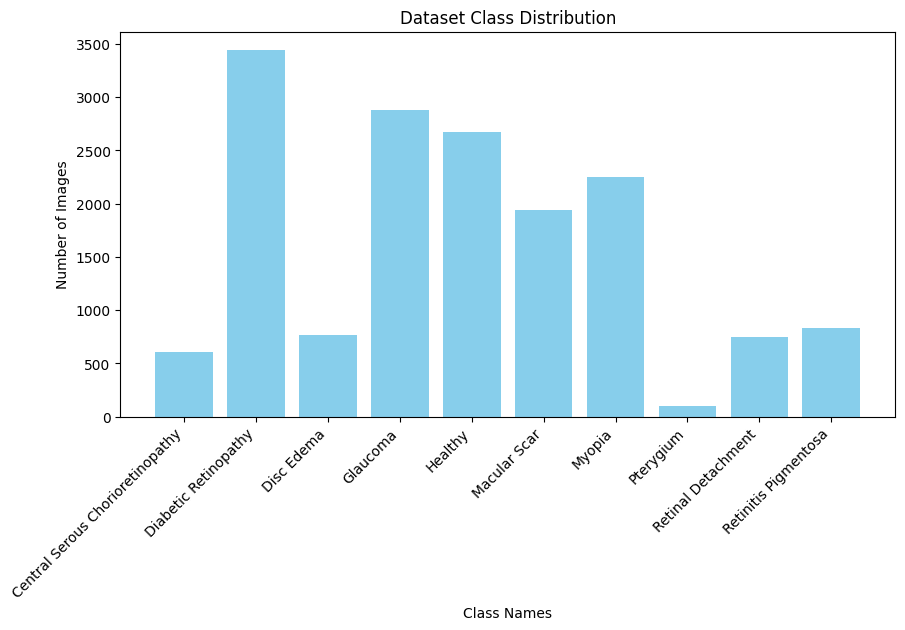

In [ ]:
dataset.show_dataset_distribution()

In [ ]:
dataset.save_class_distribution_csv()


`class_distribution.csv` file saved successfully!


# Training with Resnet

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter


2025-11-19 14:31:52.335633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763562712.583711      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763562712.653643      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
class EyeDiseaseClassifier:
    def __init__(self, num_classes=10, optimizer_name="AdamW", learning_rate=1e-4, weight_decay=1e-4, patience=5, device=None):
        self.num_classes = num_classes
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

        # Load Pretrained ResNet50
        self.model = models.resnet50(weights=True)
        
        # Modify Final Layer for num_classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, self.num_classes)
        self.model = self.model.to(self.device)

        # Loss Function
        self.criterion = nn.CrossEntropyLoss()

        # Choose Optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.optimizer = self.get_optimizer(optimizer_name)

        # Learning Rate Scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        # Early Stopping
        self.best_val_loss = float('inf')
        self.patience = patience
        self.early_stop_counter = 0

        # TensorBoard Logging
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.writer = SummaryWriter(log_dir=f"runs/eye_disease_classifier_{timestamp}")

        # Store loss & accuracy
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []

        # Best Model Saving
        self.best_model_path = f"best_model_{timestamp}.pth"

    def get_optimizer(self, optimizer_name):
        optimizers = {
            "AdamW": optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay),
            "Adam": optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay),
            "SGD": optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=self.weight_decay),
        }
        return optimizers.get(optimizer_name, optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay))
    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

            train_acc = 100. * correct / total
            # Validation Step
            val_loss, val_acc, _, _, _, _ = self.evaluate(val_loader, class_labels=class_labels, print_report=False)
            self.train_losses.append(train_loss / len(train_loader))
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])

            self.writer.add_scalar("Loss/Train", self.train_losses[-1], epoch)
            self.writer.add_scalar("Loss/Validation", val_loss, epoch)
            self.writer.add_scalar("Accuracy/Train", train_acc, epoch)
            self.writer.add_scalar("Accuracy/Validation", val_acc, epoch)
            self.writer.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            self.scheduler.step(val_loss)

            print(f"Epoch {epoch+1}: Train Loss={self.train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

            # Early Stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
                torch.save(self.model.state_dict(), self.best_model_path)
                print("✅ Best model saved!")
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("⏹️ Early stopping triggered!")
                    break
    def evaluate(self, val_loader, class_labels, print_report=True):
        self.model.eval()
        correct, total, val_loss = 0, 0, 0
        all_preds, all_labels = [], []
        class_correct = [0] * self.num_classes
        class_total = [0] * self.num_classes
        misclassified_samples = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
    
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                for img, pred, true in zip(images.cpu(), predicted.cpu(), labels.cpu()):
                    if pred != true:
                        misclassified_samples.append((img, class_labels[true], class_labels[pred]))
                
                for i in range(len(labels)):
                    label = labels[i].item()
                    class_total[label] += 1
                    if predicted[i].item() == label:
                        class_correct[label] += 1
        # Compute Metrics
        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        # Per-Class Accuracy
        class_accuracies = {class_labels[i]: (100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0) for i in range(self.num_classes)}
        
        pred_counts = Counter(all_preds)
        if print_report:
            print("📊 Classification Report:\n", classification_report(
                all_labels, 
                all_preds, 
                labels=list(range(len(class_labels))), 
                target_names=class_labels, 
                zero_division=0  
            ))

            cm = confusion_matrix(all_labels, all_preds)
        
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title("Confusion Matrix")
            plt.show()

            print("Per-Class Accuracy:")
            for cls, acc in class_accuracies.items():
                print(f"{cls}: {acc:.2f}%")
    
        return val_loss / len(val_loader), accuracy, precision, recall, f1, misclassified_samples

    def test(self, test_loader, class_labels):
        print("Evaluating on Test Set...")
        _, test_acc, test_precision, test_recall, test_f1, _ = self.evaluate(test_loader, class_labels=class_labels)
        print(f"Test Accuracy: {test_acc:.2f}%, Precision: {test_precision:.2f}%, Recall: {test_recall:.2f}%, F1-score: {test_f1:.2f}%")

    def load_best_model(self):
        print("🔄 Loading best model...")
        self.model.load_state_dict(torch.load(self.best_model_path))
        self.model.to(self.device)

    def hyperparameter_search(self, train_loader, val_loader, class_labels, 
                             optimizers=["AdamW", "SGD", "Adam"], 
                             learning_rates=[1e-3, 1e-5],
                             weight_decays=[1e-6, 1e-3],
                             momentums = [0.9, 0.95],
                             epochs = 10):
        """
        Performs a hyperparameter search to find the best combination of optimizer, learning rate, and weight decay.
        """
        best_accuracy = 0
        best_params = None

        for opt in optimizers:
          for lr in learning_rates:
              for wd in weight_decays:
                if opt == "SGD":
                    for momentum in momentums:
                      print(f"\n🔍 Training with Optimizer: {opt}, Learning Rate: {lr}, Weight Decay: {wd}, Momentum: {momentum}")
                      classifier = EyeDiseaseClassifier(num_classes=self.num_classes, optimizer_name=opt, learning_rate=lr, weight_decay=wd, device=self.device)
                      # Set momentum for SGD optimizer
                      for g in classifier.optimizer.param_groups:
                        g['momentum'] = momentum
                      classifier.train(train_loader, val_loader, num_epochs=epochs)
                      _, val_acc, _, _, _, _ = classifier.evaluate(val_loader, class_labels=class_labels)

                      if val_acc > best_accuracy:
                          best_accuracy = val_acc
                          best_params = (opt, lr, wd, momentum)
                else:
                    print(f"\n🔍 Training with Optimizer: {opt}, Learning Rate: {lr}, Weight Decay: {wd}")
                    classifier = EyeDiseaseClassifier(num_classes=self.num_classes, optimizer_name=opt, learning_rate=lr, weight_decay=wd, device=self.device)
                    classifier.train(train_loader, val_loader, num_epochs=epochs)
                    _, val_acc, _, _, _, _ = classifier.evaluate(val_loader, class_labels=class_labels)

                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        best_params = (opt, lr, wd)

        print(f"\nBest Hyperparameters: {best_params} with Accuracy: {best_accuracy:.2f}%")

    def plot_loss_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

    def plot_accuracy_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.show()

    def plot_learning_rate_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.learning_rates, label='Learning Rate', color='r')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.show()

## Hyperparameter Search Grid Search

In [11]:
#find_param = EyeDiseaseClassifier(num_classes=10)

In [12]:
#find_param.hyperparameter_search(train_loader, val_loader, class_labels, epochs = 3)

### Training with best parameter

In [13]:
num_classes=10
optimizer_name='AdamW'
learning_rate=1e-05
weight_decay=0.001
patience=10

In [14]:
classifier = EyeDiseaseClassifier(
                num_classes=10, 
                optimizer_name=optimizer_name,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                patience=patience
            )

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
test = EyeDiseaseClassifier(
                num_classes=10, 
                optimizer_name=optimizer_name,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                patience=patience
            )

In [ ]:
classifier.train(train_loader, val_loader, num_epochs=20)

Epoch 1/50: 100%|██████████| 356/356 [09:28<00:00,  1.60s/it, acc=61, loss=1.24]   


Epoch 1: Train Loss=1.1990, Val Loss=0.6470, Val Acc=79.50%
✅ Best model saved!


Epoch 2/50: 100%|██████████| 356/356 [08:01<00:00,  1.35s/it, acc=82.2, loss=0.27] 


Epoch 2: Train Loss=0.5442, Val Loss=0.4410, Val Acc=83.96%
✅ Best model saved!


Epoch 3/50: 100%|██████████| 356/356 [08:14<00:00,  1.39s/it, acc=88.6, loss=1.17]  


Epoch 3: Train Loss=0.3400, Val Loss=0.3841, Val Acc=86.33%
✅ Best model saved!


Epoch 4/50: 100%|██████████| 356/356 [08:11<00:00,  1.38s/it, acc=91.8, loss=0.29]  


Epoch 4: Train Loss=0.2461, Val Loss=0.3832, Val Acc=86.18%
✅ Best model saved!


Epoch 5/50: 100%|██████████| 356/356 [07:57<00:00,  1.34s/it, acc=93.5, loss=0.147] 


Epoch 5: Train Loss=0.1895, Val Loss=0.4043, Val Acc=85.81%


Epoch 6/50: 100%|██████████| 356/356 [07:40<00:00,  1.29s/it, acc=93.9, loss=0.34]  


Epoch 6: Train Loss=0.1722, Val Loss=0.4027, Val Acc=86.55%


Epoch 7/50: 100%|██████████| 356/356 [07:40<00:00,  1.29s/it, acc=94.4, loss=0.575] 


Epoch 7: Train Loss=0.1506, Val Loss=0.4029, Val Acc=86.80%


Epoch 8/50: 100%|██████████| 356/356 [07:40<00:00,  1.29s/it, acc=94.5, loss=0.279] 


Epoch 8: Train Loss=0.1405, Val Loss=0.4022, Val Acc=86.77%


Epoch 9/50: 100%|██████████| 356/356 [07:43<00:00,  1.30s/it, acc=95.6, loss=0.0945]


Epoch 9: Train Loss=0.1100, Val Loss=0.4065, Val Acc=87.32%


Epoch 10/50: 100%|██████████| 356/356 [07:40<00:00,  1.29s/it, acc=95.7, loss=0.0714]


Epoch 10: Train Loss=0.1016, Val Loss=0.4128, Val Acc=87.32%


Epoch 11/50: 100%|██████████| 356/356 [07:40<00:00,  1.29s/it, acc=95.8, loss=0.0817]


Epoch 11: Train Loss=0.0954, Val Loss=0.4212, Val Acc=87.29%


Epoch 12/50: 100%|██████████| 356/356 [07:42<00:00,  1.30s/it, acc=95.6, loss=0.572] 


Epoch 12: Train Loss=0.0979, Val Loss=0.4224, Val Acc=87.26%


Epoch 13/50: 100%|██████████| 356/356 [07:43<00:00,  1.30s/it, acc=95.7, loss=0.384] 


Epoch 13: Train Loss=0.0931, Val Loss=0.4272, Val Acc=87.41%


Epoch 14/50: 100%|██████████| 356/356 [07:41<00:00,  1.30s/it, acc=96, loss=0.0403]  


Epoch 14: Train Loss=0.0898, Val Loss=0.4278, Val Acc=87.29%
⏹️ Early stopping triggered!


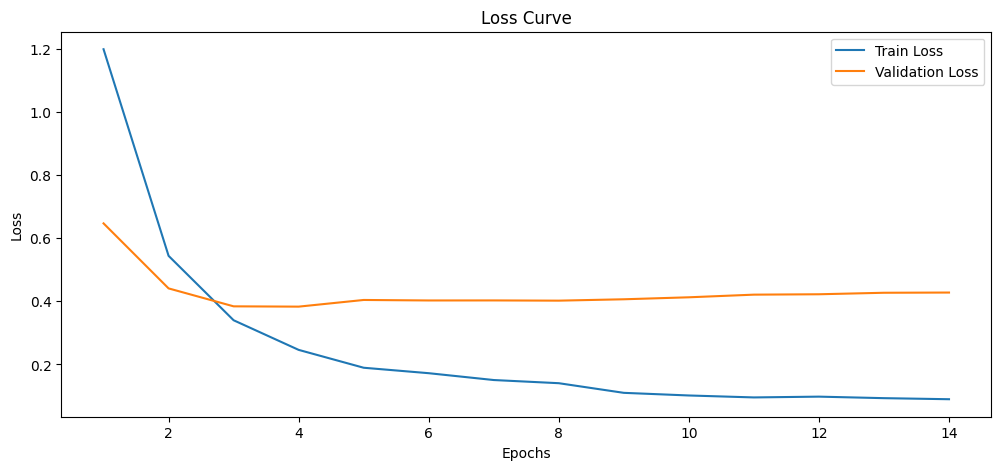

In [17]:
classifier.plot_loss_curve()

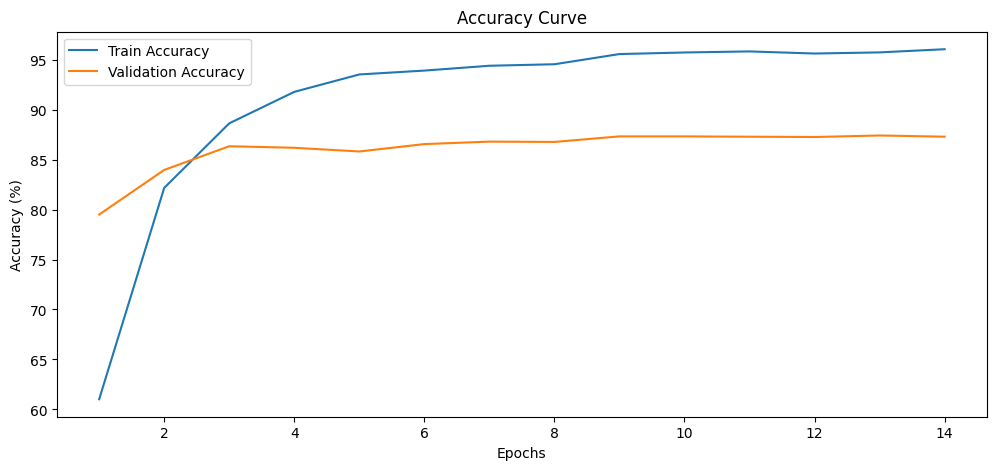

In [18]:
classifier.plot_accuracy_curve()

In [19]:
state_dict = torch.load(classifier.best_model_path, weights_only=True)
classifier.model.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
## Training Report
#classifier.evaluate(train_loader,class_labels)

📊 Classification Report:
                                   precision    recall  f1-score   support

Central Serous Chorioretinopathy       0.79      0.79      0.79       121
            Diabetic Retinopathy       0.96      0.96      0.96       689
                      Disc Edema       0.94      0.90      0.92       153
                        Glaucoma       0.75      0.79      0.77       576
                         Healthy       0.85      0.81      0.83       535
                    Macular Scar       0.82      0.79      0.81       387
                          Myopia       0.82      0.85      0.84       450
                       Pterygium       1.00      1.00      1.00        21
              Retinal Detachment       0.96      0.99      0.98       150
            Retinitis Pigmentosa       0.95      0.95      0.95       167

                        accuracy                           0.86      3249
                       macro avg       0.89      0.88      0.88      3249
          

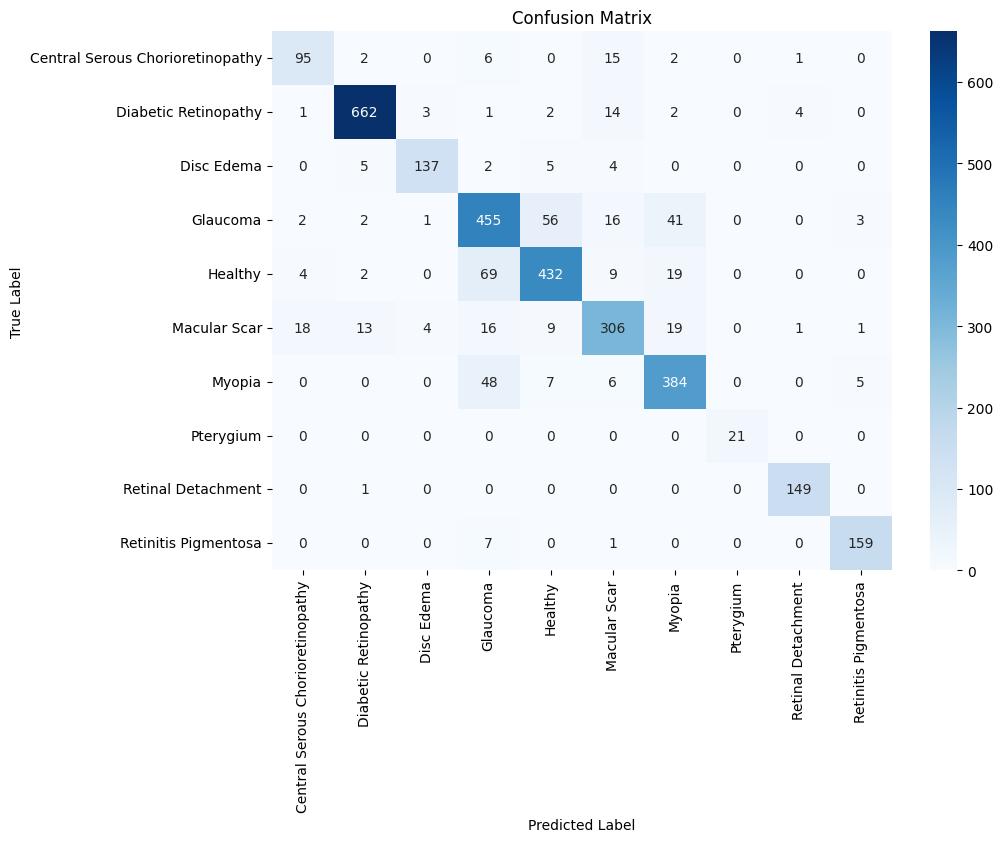

Per-Class Accuracy:
Central Serous Chorioretinopathy: 78.51%
Diabetic Retinopathy: 96.08%
Disc Edema: 89.54%
Glaucoma: 78.99%
Healthy: 80.75%
Macular Scar: 79.07%
Myopia: 85.33%
Pterygium: 100.00%
Retinal Detachment: 99.33%
Retinitis Pigmentosa: 95.21%


(0.38318325966304423,
 86.18036318867344,
 86.27084391170638,
 86.18036318867344,
 86.19798939554396,
 [(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],
   
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ...,

In [21]:
# Validation Report
classifier.evaluate(val_loader,class_labels)

Evaluating on Test Set...
📊 Classification Report:
                                   precision    recall  f1-score   support

Central Serous Chorioretinopathy       0.87      0.74      0.80        61
            Diabetic Retinopathy       0.97      0.94      0.95       345
                      Disc Edema       0.97      0.91      0.94        76
                        Glaucoma       0.71      0.79      0.75       288
                         Healthy       0.81      0.79      0.80       268
                    Macular Scar       0.79      0.77      0.78       194
                          Myopia       0.81      0.84      0.82       225
                       Pterygium       1.00      1.00      1.00        10
              Retinal Detachment       0.97      0.99      0.98        75
            Retinitis Pigmentosa       0.95      0.95      0.95        83

                        accuracy                           0.85      1625
                       macro avg       0.89      0.87     

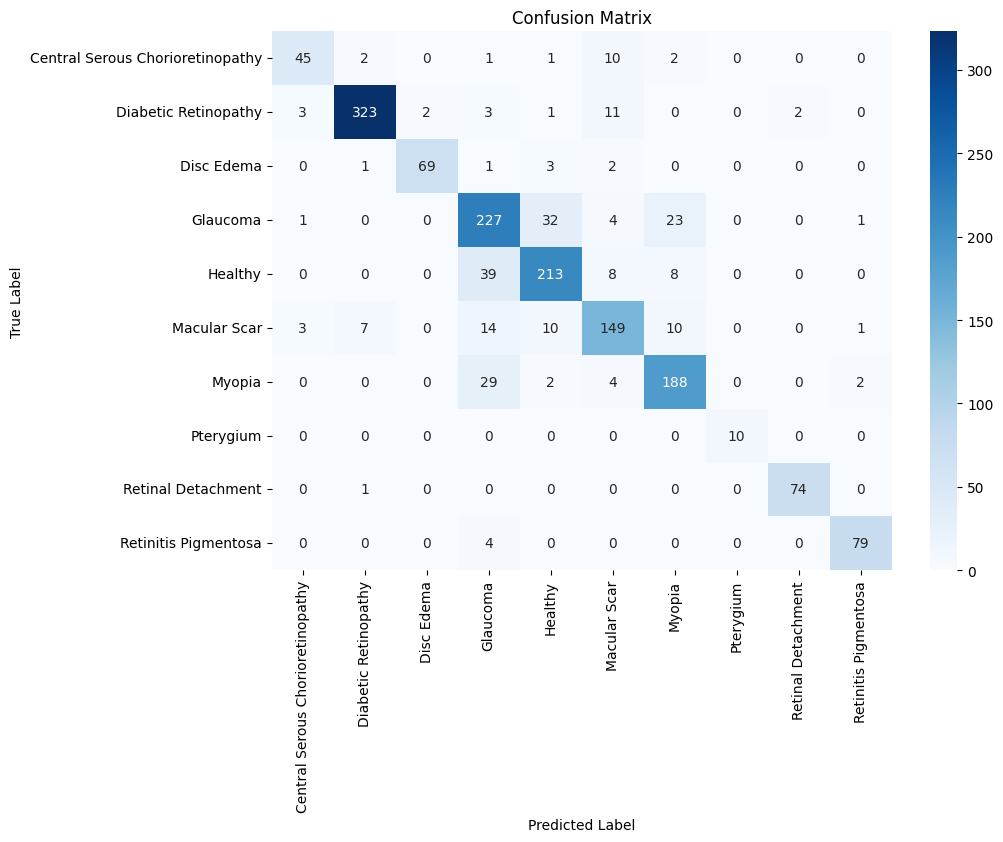

Per-Class Accuracy:
Central Serous Chorioretinopathy: 73.77%
Diabetic Retinopathy: 93.62%
Disc Edema: 90.79%
Glaucoma: 78.82%
Healthy: 79.48%
Macular Scar: 76.80%
Myopia: 83.56%
Pterygium: 100.00%
Retinal Detachment: 98.67%
Retinitis Pigmentosa: 95.18%
Test Accuracy: 84.74%, Precision: 85.09%, Recall: 84.74%, F1-score: 84.84%


In [22]:
# Test Report
classifier.test(test_loader, class_labels)

## Applying xAI 

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

### Applying GradCAM

In [24]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        self.target_layer = target_layer

        # Hook to capture feature maps (forward hook)
        def forward_hook(module, input, output):
            self.activations = output  # Store feature maps
        
        # Hook to capture gradients (backward hook)
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Store gradients

        # Register the hooks
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, image, class_idx=None):
        image = image.unsqueeze(0).to(next(self.model.parameters()).device)
        self.model.zero_grad()

        # Forward pass
        output = self.model(image)
        
        # If class index is not provided, take the highest probability class
        if class_idx is None:
            class_idx = output.argmax().item()

        # Compute gradients w.r.t the target class
        score = output[0, class_idx]
        score.backward()

        # Get the gradients and feature maps
        gradients = self.gradients.cpu().data.numpy()
        feature_maps = self.activations.cpu().data.numpy()[0]  # Corrected

        # Compute weighted sum of feature maps using gradients
        weights = np.mean(gradients, axis=(1, 2))  # Global Average Pooling
        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * feature_maps[i]

        # Normalize the CAM
        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (224, 224))  # Resize to image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

    def overlay_heatmap(self, original_image, cam, alpha=0.4):
        # Ensure image is in the correct format
        if isinstance(original_image, Image.Image):  # If it's a PIL image, convert to numpy
            original_image = np.array(original_image)
    
        # Resize CAM to match the original image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    
        # Normalize heatmap
        cam_resized = (cam_resized * 255).astype(np.uint8)
    
        # Convert grayscale heatmap to color
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    
        # Convert original image to BGR format if it's in RGB
        if original_image.shape[-1] == 3:  # Check if it's already RGB
            original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        else:
            original_image_bgr = original_image
    
        # Overlay heatmap onto original image
        overlay = cv2.addWeighted(original_image_bgr, 1 - alpha, heatmap, alpha, 0)
    
        # Convert back to RGB for displaying
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
        return overlay_rgb


# Function to process image and apply Grad-CAM
def apply_gradcam(model, image_path, class_names):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(Image.open(image_path).convert("RGB"))
    original_image = np.array(Image.open(image_path).convert("RGB"))

    # Choose the target layer (last convolutional layer)
    target_layer = model.model.layer4[-1]  # Last conv layer in ResNet50

    # Apply Grad-CAM
    grad_cam = GradCAM(model.model, target_layer)  # Pass model.model
    cam = grad_cam.generate_cam(image)

    # Overlay heatmap
    result = grad_cam.overlay_heatmap(original_image, cam)

    # Show images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f"Grad-CAM Heatmap")
    plt.axis("off")

    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipykernel_48/761662311.py:59: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)
/tmp/ipykernel_48/761662311.py:72: RuntimeWarning: invalid value encountered in cast
  cam_resized = (cam_resized * 255).astype(np.uint8)


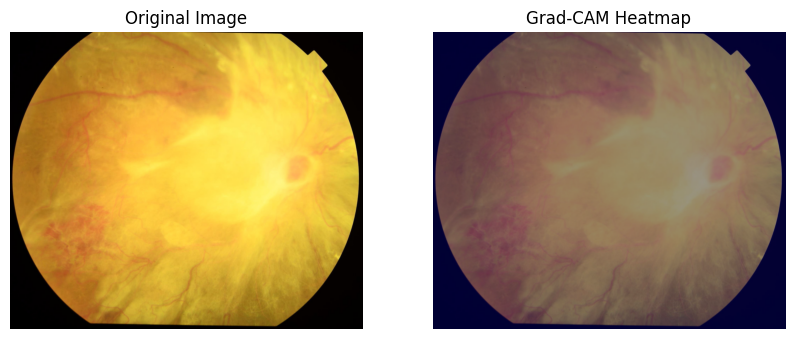

In [25]:
state_dict = torch.load(classifier.best_model_path, weights_only=True)
classifier.model.load_state_dict(state_dict)
apply_gradcam(classifier, "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Diabetic Retinopathy/DR1.jpg", class_names=class_labels)


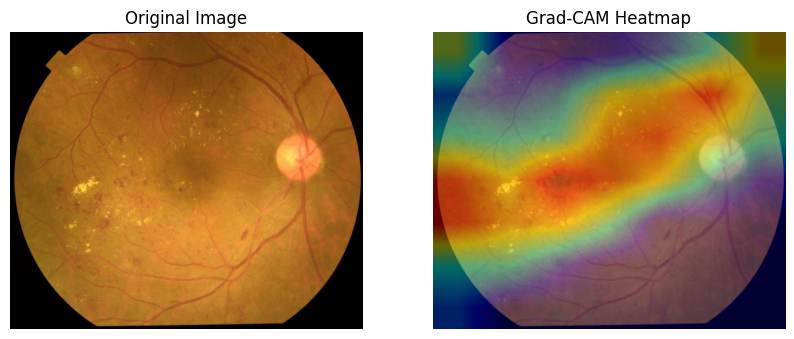

In [26]:
apply_gradcam(
    classifier,
    "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Diabetic Retinopathy/DR1021.jpg",
    class_names=class_labels
)


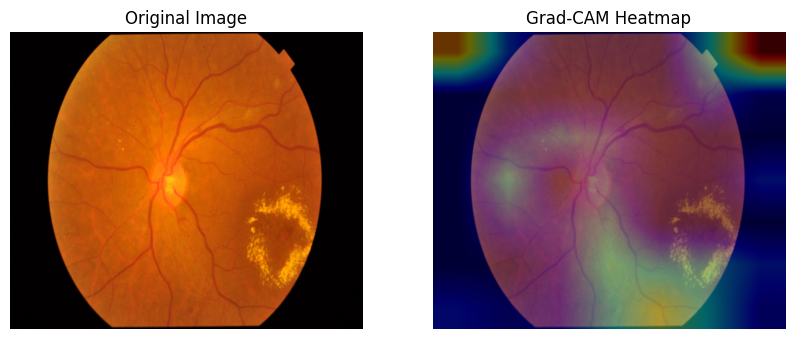

In [27]:
apply_gradcam(
    classifier,
    "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Diabetic Retinopathy/DR1051.jpg",
    class_names=class_labels
)


In [28]:
def plot_misclassified_samples(misclassified_samples, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Misclassified Samples", fontsize=16)

    for i, (img, true_label, pred_label) in enumerate(misclassified_samples[:num_samples]):
        ax = axes[i // 5, i % 5]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [29]:
import os
import torchvision.transforms as transforms
from PIL import Image

def save_misclassified_samples(misclassified_samples, save_dir):
    """
    Save misclassified images in a structured directory.
    
    Parameters:
        misclassified_samples (list): List of (image, true_label, predicted_label)
        save_dir (str): Root directory to save misclassified samples.
    """
    os.makedirs(save_dir, exist_ok=True)

    transform = transforms.ToPILImage()  # Convert tensor to PIL Image

    for idx, (img, true_label, pred_label) in enumerate(misclassified_samples):
        subdir = os.path.join(save_dir, f"{true_label}_as_{pred_label}")
        os.makedirs(subdir, exist_ok=True)

        image_path = os.path.join(subdir, f"image_{idx}.jpg")
        img = transform(img)  # Convert tensor to PIL Image
        img.save(image_path)

    print(f"Misclassified samples saved in '{save_dir}' directory.")



In [30]:
_, _, _, _, _, misclassified_samples = classifier.evaluate(val_loader,class_labels, print_report=False)

In [31]:
print(len(misclassified_samples))

449


In [32]:
dir = "/kaggle/working/val_mismatch"

In [33]:
save_misclassified_samples(misclassified_samples,dir)

Misclassified samples saved in '/kaggle/working/val_mismatch' directory.


In [34]:
import shutil

zip_name = "val_misclassified_samples.zip"

# Zip the folder
shutil.make_archive(zip_name.replace(".zip", ""), 'zip', dir)

print(f"Folder '{dir}' has been zipped as '{zip_name}'")


Folder '/kaggle/working/val_mismatch' has been zipped as 'val_misclassified_samples.zip'


In [35]:
from IPython.display import FileLink

# Create a download link
FileLink(zip_name)

/kaggle/working/val_misclassified_samples.zip

# Gradcam of Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

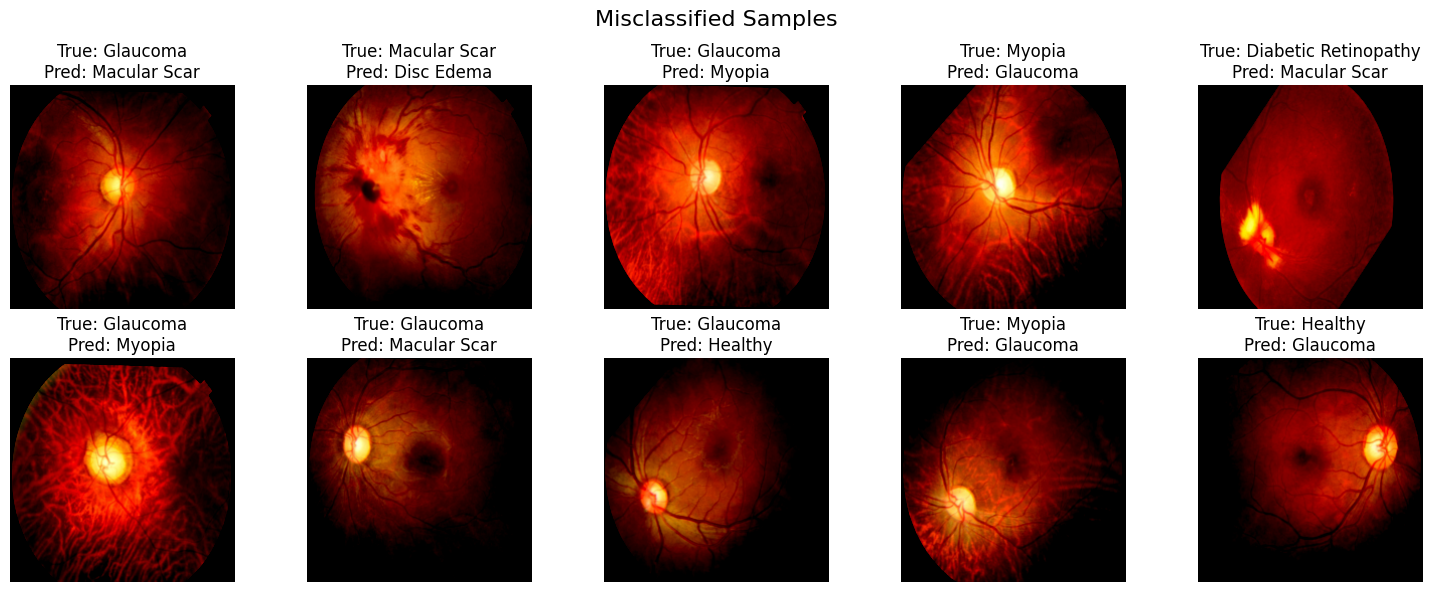

In [36]:
plot_misclassified_samples(misclassified_samples)

In [37]:
_, _, _, _, _, test_misclassified_samples = classifier.evaluate(test_loader,class_labels, print_report=False)

In [38]:
print(len(test_misclassified_samples))

248


In [39]:
test_dir = "/kaggle/working/test_mismatch"

In [40]:
save_misclassified_samples(test_misclassified_samples,test_dir)

Misclassified samples saved in '/kaggle/working/test_mismatch' directory.


In [41]:
import shutil

zip_name = "test_misclassified_samples.zip"

# Zip the folder
shutil.make_archive(zip_name.replace(".zip", ""), 'zip', test_dir)

print(f"Folder '{test_dir}' has been zipped as '{zip_name}'")


Folder '/kaggle/working/test_mismatch' has been zipped as 'test_misclassified_samples.zip'


In [42]:
from IPython.display import FileLink

# Create a download link
FileLink(zip_name)

/kaggle/working/test_misclassified_samples.zip

# Misclassified Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

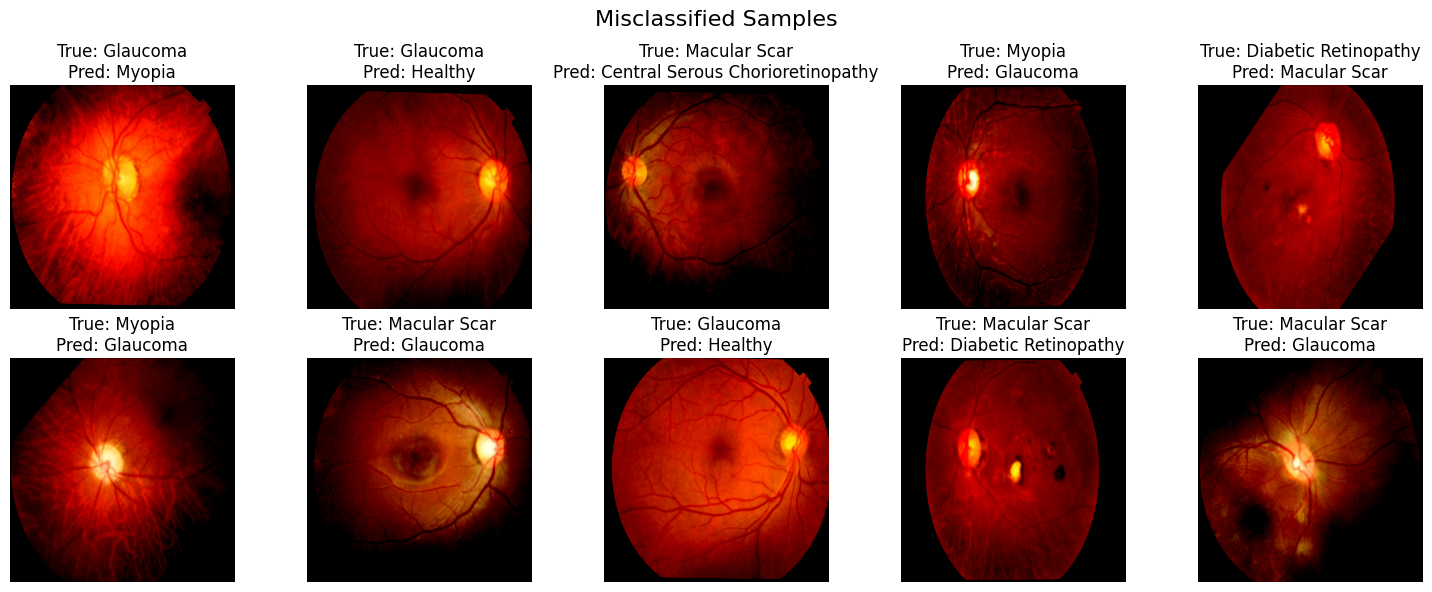

In [43]:
plot_misclassified_samples(test_misclassified_samples)